# LSTMによる予測誤差に基づく異常検知
Original source from https://qiita.com/Kenta-Itasaka/items/4ab434299730af0fe7f0
過去の10個のデータから次の3つを予測する学習を行っています。
予測結果の３つのサンプルの誤差の操作でもいいと思いますが，ここでは，それぞれの誤差分布を測定しておいてその偏りをマハラノビス距離で正規化してから誤差を評価しています。

In [1]:
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


### マハラノビス距離

In [2]:
def Mahalanobis_dist(x, mean, cov):
    d = np.dot(x-mean, np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

### 学習データ、検証データ、テストデータに分割するジェネレータ

In [3]:
def generator(data, lookback, delay, pred_length, min_index, max_index, shuffle=False,
              batch_size=100, step=1):
    if max_index is None:
        max_index = len(data) - delay - pred_length - 1 
    i = min_index + lookback 

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, 
                                    size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                               lookback//step,
                               data.shape[-1]))

        targets = np.zeros((len(rows), pred_length))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay : rows[j] + delay + pred_length].flatten()

        yield samples, targets

### データ読み込みと正規化

In [4]:
data = np.loadtxt("ipynbs/qtdbsel102.txt",delimiter="\t")
print("データ数:",data.shape[0],"  次元数:",data.shape[1])
ecg = data[:,2]
ecg = ecg.reshape(len(ecg), -1)
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

データ数: 45000   次元数: 3


In [5]:
normal_cycle = std_ecg[5000:]
lookback = 10
pred_length = 3
step = 1
delay = 1
batch_size = 100

In [6]:
# 訓練データ
train_gen = generator(normal_cycle, 
                     lookback=lookback,
                     pred_length=pred_length,
                     delay=delay,
                     min_index=0,
                     max_index=20000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
# バリデーションデータ
val_gen = generator(normal_cycle, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=20001,
                   max_index=30000,
                   step=step,
                   batch_size=batch_size)


# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (30001 - 20001 -lookback) // batch_size


## LSTMモデルの設計と学習

In [7]:
model = Sequential()
model.add(layers.LSTM(35, return_sequences = True, input_shape=(None,normal_cycle.shape[-1])))
model.add(layers.LSTM(35))
model.add(layers.Dense(pred_length))

model.compile(optimizer=RMSprop(), loss="mse")
history = model.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
200/200 [==============================] - 6s 28ms/step - loss: 0.1776 - val_loss: 0.0452
Epoch 2/60
200/200 [==============================] - 3s 17ms/step - loss: 0.0323 - val_loss: 0.0188
Epoch 3/60
200/200 [==============================] - 4s 22ms/step - loss: 0.0189 - val_loss: 0.0161
Epoch 4/60
200/200 [==============================] - 4s 21ms/step - loss: 0.0155 - val_loss: 0.0126
Epoch 5/60
200/200 [==============================] - 4s 22ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 6/60
200/200 [==============================] - 4s 21ms/step - loss: 0.0119 - val_loss: 0.0105
Epoch 7/60
200/200 [==============================] - 4s 21ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 8/60
200/200 [==============================] - 4s 21ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 9/60
200/200 [==============================] - 4s 22ms/step - los

### 学習曲線の確認

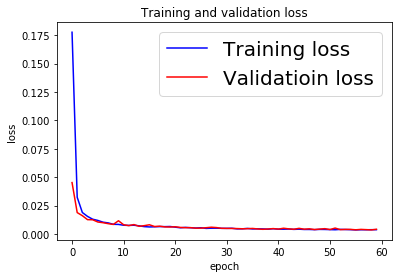

In [8]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validatioin loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and validation loss")
plt.legend(fontsize=20)

plt.show()

## テストデータに対する誤差評価

In [34]:
test_gen_pred = generator(normal_cycle, 
                    lookback=lookback,
                    pred_length=pred_length,
                    delay=delay,
                    min_index=30001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

test_steps = (len(normal_cycle) - 30001 - lookback) // batch_size

test_pred = model.predict_generator(test_gen_pred, steps=test_steps)

In [35]:
test_gen_target = generator(normal_cycle, 
                    lookback=lookback,
                    pred_length=pred_length,
                    delay=delay,
                    min_index=30001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

test_target = np.zeros((test_steps * batch_size , pred_length))

for i in range(test_steps):
    test_target[i*batch_size:(i+1)*batch_size] = next(test_gen_target)[1]

## 誤差の統計情報の計算　あとでマハラノビス距離を求めるのにつかう

In [36]:
error =  test_pred - test_target
mean = np.mean(error, axis=0)
cov = np.cov(error, rowvar=False, bias=True)
print(mean, cov)

[ 0.00477473 -0.00308476 -0.00651492] [[0.00169263 0.0016412  0.00175989]
 [0.0016412  0.00305514 0.00350793]
 [0.00175989 0.00350793 0.00564957]]


## 異常検知

In [37]:
detection_gen_pred = generator(std_ecg, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=0,
                   max_index=5000,
                   step=step,
                   batch_size=batch_size)

detection_steps = (5000 -lookback) // batch_size

detection_pred = model.predict_generator(detection_gen_pred, steps=detection_steps)

In [38]:
detection_gen_target = generator(std_ecg, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=0,
                   max_index=5000,
                   step=step,
                   batch_size=batch_size)

detection_target = np.zeros((detection_steps * batch_size , pred_length))

for i in range(detection_steps):
    detection_target[i*batch_size:(i+1)*batch_size] = next(detection_gen_target)[1]

## 予測誤差の評価

In [39]:
error_detection = detection_pred - detection_target 

m_dist = []

for e in error_detection:
    m_dist.append(Mahalanobis_dist(e, mean, cov))

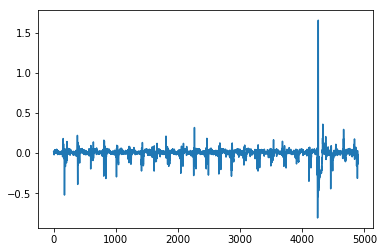

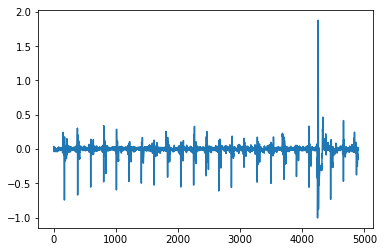

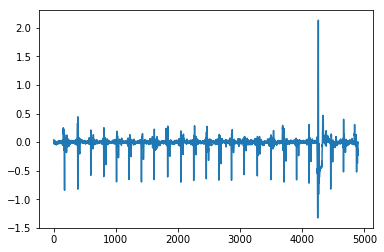

In [44]:
plt.plot(error_detection.T[0])
plt.show()
plt.plot(error_detection.T[1])
plt.show()
plt.plot(error_detection.T[2])
plt.show()

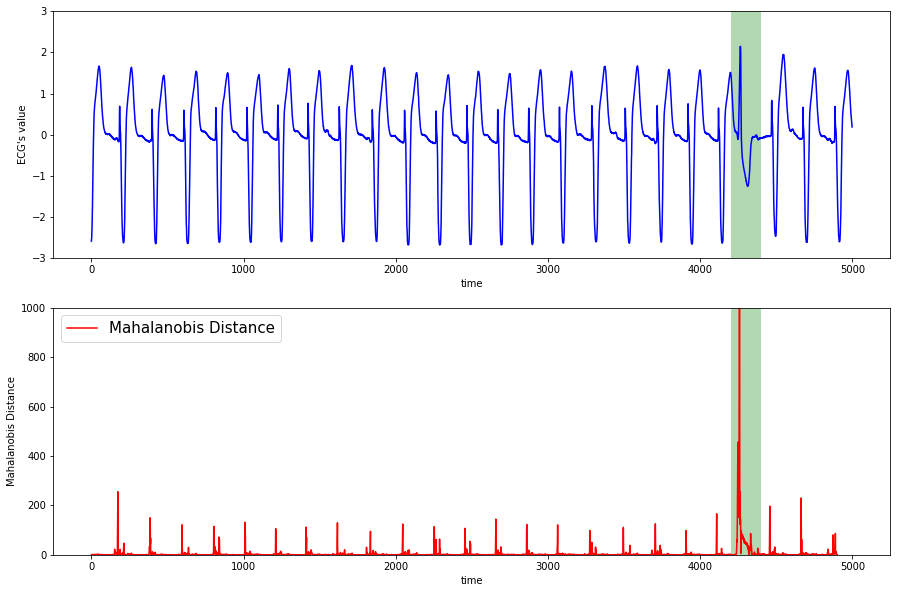

In [32]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_xlim(-250, 5250)
axes[0].set_ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_xlim(-250, 5250)
axes[1].set_ylim(0, 1000)
y1 = [0]*len(x)
y2 = [1000]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()